In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install lime==0.2.0.1
!pip install shap==0.35.0
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "production"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"],#, "sepsis_cases_2", "sepsis_cases_4"]
    "production": ["production"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['production']

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])-1
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets

            print(max_prefix)
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

Output hidden; open in https://colab.research.google.com to view.

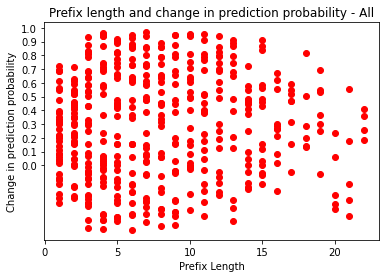

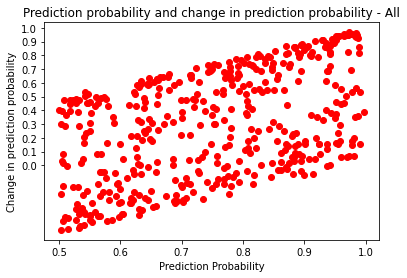

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

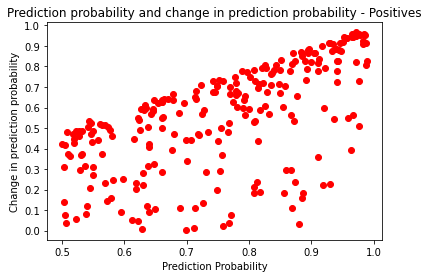

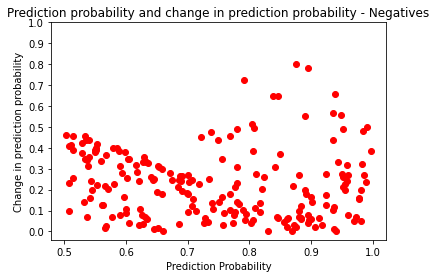

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

In [13]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])-1
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

Output hidden; open in https://colab.research.google.com to view.

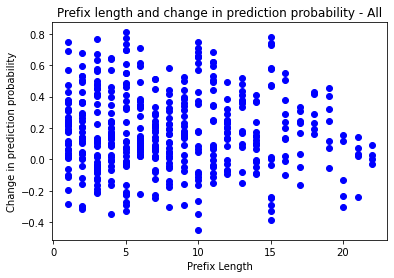

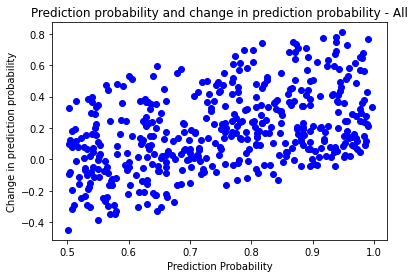

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

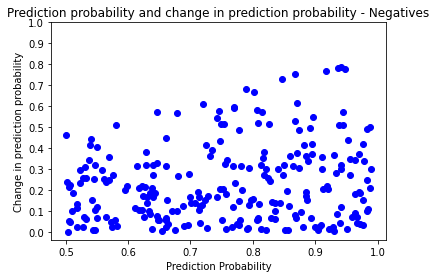

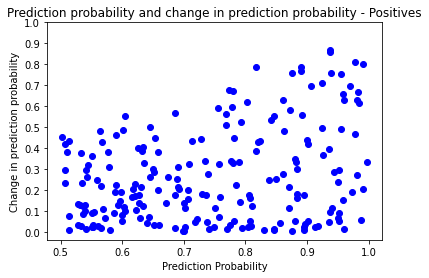

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [16]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

LIME Fidelity Score: 0.17998694368057053 
SHAP Fidelity Score: 0.2952213307380044


In [17]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

Positive predictions: 
LIME Fidelity Score: 0.23296834980099787 
SHAP Fidelity Score: 0.5522456956323145
Negative predictions: 
LIME Fidelity Score: 0.26963823078905497 
SHAP Fidelity Score: 0.22954910733167408
